In [24]:
import json
import numpy as np
import os
from PIL import Image, ImageDraw
from collections import defaultdict

from matplotlib import pyplot as plt
from matplotlib import animation as animation

from torchvision import transforms
from transformers import AutoTokenizer

In [4]:
path = "/data/users/jmorales/model_files/DocILE_DRAM/docile_ng10_bs128_ps32"
res_file = [i for i in os.listdir(path) if "results.json" in i][0]
res_file = os.path.join(path, res_file)

with open(res_file, "r") as f:
    results = json.load(f)

### Visualizing glimpses

In [35]:
def create_gif(img, locs, patch_size, resize_factor, out_file):
    # create draw object
    gif_image = img.copy()
    line_draw = ImageDraw.Draw(gif_image)

    frames = []
    for i in range(len(locs)):
        point = locs[i]

        if i != 0:
            # All frames share the drawing of the line connecting glimpses
            line_draw.line((*prev_point, *point), fill="white")

        # In each frame only one glimpse will be visible, 
        frame = gif_image.copy()
        frame_draw = ImageDraw.Draw(frame)

        # draw center glimpse point
        frame_draw.point(point, fill="red")

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.ellipse(shape, outline="red")

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.rectangle(shape, outline="red")

        # update previous point
        prev_point = point
        
        # save frame
        frames.append(frame)

    # Set the initial frame
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], animated=True)

    def update(i):
        im.set_array(frames[i])
        return im

    # Create the animation (GIF)
    animation_fig = animation.FuncAnimation(
        fig, update, frames=len(frames), interval=400, blit=False, repeat_delay=200)
    animation_fig.save(out_file)

    return frames

def preprocess(answer_bbox, img):
    """
        Follow the preprocessing mentioned in [1]:

        TODO CHANGE THIS, same preprocessing but will a single answer bbox
        "Find the small rectangular bounding box that will 
        contain individual character bounding boxes. We then
        expand this bounding box by 30% in both the x and 
        the y direction, crop the image to that bounding box
        and resize the crop to 64x64 pixels. We then crop a 
        54x54 pixel image from a random location within the 
        64x64 pixel image."

        [1] Ian J. Goodfellow et al. "Multi-digit Number Recognition
            from Street View Imagery using Deep Convolutional Neural Networks"
    """
    w, h = img.size
    
    x1_, y1_, x2_, y2_ = int(answer_bbox[0]*w), int(answer_bbox[1]*h), int(answer_bbox[2]*w), int(answer_bbox[3]*h)

    # Expand this bbox by 30% in both x and y axis
    x1 = int(max(0, x1_ - 0.15*(x2_-x1_)))
    y1 = int(max(0, y1_ - 0.15*(y2_-y1_)))
    x2 = int(min(w, x2_ + 0.15*(x2_-x1_)))
    y2 = int(min(h, y2_ + 0.15*(y2_-y1_)))

    # Crop image
    img = img.crop((x1, y1, x2, y2))

    return img


def visualize_glimpses(sample, patch_size, tokenizer, save_gif=False, out_file=None):
    # Number of correctly pred
    #pred_digits = np.array()[(np.array(sample["pred"]) != -100)]
    pred_digits = tokenizer.decode(sample["pred"], skip_special_tokens=False)
    print(sample["pred"])
    gt_labels = tokenizer.decode(sample["labels"], skip_special_tokens=False)

    print(f"GT: {gt_labels}")
    print(f"Predicted digits: {pred_digits}")

    # load image and normalize
    img = Image.open(sample["img_path"])
    img = preprocess(sample["answer_bbox"], img)
    w, h = img.size
    
    transf = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.CenterCrop((96, 96))])
    
    img = transf(img)

    # Resize to be visible
    resize_factor = 1
    img = img.resize((w*resize_factor, h*resize_factor))
    w, h = img.size

    # convert glimpse locations to pixel space
    locs = [[(i + 1)/2 * w, (j + 1)/2 * h] for i,j in sample["locs"]]
    
    # create draw object
    draw_img = img.copy()
    draw = ImageDraw.Draw(draw_img)

    for i in range(len(locs)):
        # draw center glimpse point
        point = locs[i]
        draw.point(point, fill="red")

        if i != 0:
            # Line joining past and current glimpse
            draw.line((*prev_point, *point), fill="white")

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.ellipse(shape, outline="red")

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.rectangle(shape, outline="red")

        # update previous point
        prev_point = point

    if save_gif:
        create_gif(img, locs, patch_size, resize_factor, out_file)

    return draw_img


[198, 198, 198, 198, 198]
GT: 29898042<|endoftext|><|endoftext|>
Predicted digits: 







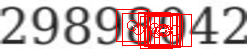

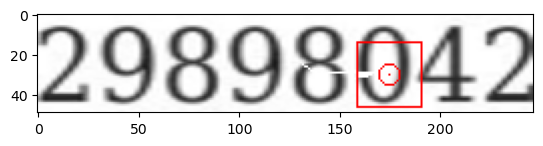

In [40]:
idx = 209
sample = results[idx]

tokenizer = AutoTokenizer.from_pretrained("gpt2")
visualize_glimpses(sample, tokenizer=tokenizer, patch_size=32, save_gif=True, out_file="plots/glimpse_docile.gif")

In [37]:
tokenizer.decode([198])

'\n'